In [17]:
from PIL import Image
import numpy as np
import pandas as pd
import random
from os import listdir
%matplotlib inline
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks

## YOLO

In [48]:
grid_w = 7
grid_h = 3

def load_photos(directory):
    images = []
    x_labels_loc = []
    y_labels_loc = []
    class_labels_loc = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        images.append(image)
        # get labels
        x_labels_loc.append(int(float(name.split('_')[1]) * grid_w))
        y_labels_loc.append(int(float(name.split('_')[2].split('.png')[0]) * grid_h))
    return images, x_labels_loc, y_labels_loc

In [59]:
dataset = "Yolo_Datas/"

# load images from both train and test groups
directory = dataset + 'Train'
images, x_labels_loc, y_labels_loc = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)

Loaded Images and labels for training: 226


In [60]:
#Normalise images
images = np.array(images)
images = images
images /= 255.0

#convert datas to dummyvalues
x_labels_loc = np.array(keras.utils.to_categorical((x_labels_loc), num_classes= grid_w))
y_labels_loc = np.array(keras.utils.to_categorical((y_labels_loc), num_classes= grid_h))

[0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0.]
(240, 320, 3)


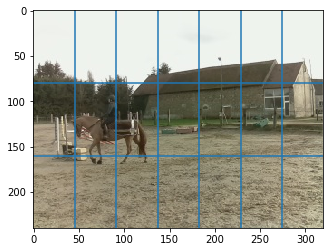

In [61]:
idx = 0

print(x_labels_loc[idx])
print(y_labels_loc[idx])
print(images[idx].shape)
plt.imshow(images[idx])

for line in range(1, grid_h):
    plt.axhline(line * images[idx].shape[0] / grid_h)
for col in range(1, grid_w):
    plt.axvline(col * images[idx].shape[1] / grid_w)

In [62]:
K.clear_session()

img_in = Input(shape=images[0].shape, name='img_in')
x = img_in

x = Convolution2D(16, (8,8), strides=(4,4), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Convolution2D(8, (4,4), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.2)(x)
x = Convolution2D(4, (2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.2)(x)

x = Flatten(name='flattened')(x)

x = Dense(1000, use_bias=False)(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Dense(500, use_bias=False)(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.2)(x)
x = Dense(50, use_bias=False)(x)  
x = BatchNormalization()(x)
x = Activation("relu")(x)

out_x = Dense(x_labels_loc.shape[1], activation='softmax')(x)
out_y = Dense(y_labels_loc.shape[1], activation='softmax')(x)

# Compile Model
model = Model(inputs=img_in, outputs=[out_x, out_y])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 79, 16)   3072        img_in[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 59, 79, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 59, 79, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [63]:
model_name="model_YOLO.h5"
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [67]:
h = model.fit(images, [x_labels_loc, y_labels_loc], batch_size=16, epochs=10, validation_split=0.2, verbose=1, callbacks=[best_checkpoint])

Train on 180 samples, validate on 46 samples
Epoch 1/10
180/180 [==============================] - 20s 110ms/step - loss: 0.3847 - dense_4_loss: 0.2852 - dense_5_loss: 0.0995 - dense_4_acc: 0.9167 - dense_5_acc: 0.9889 - val_loss: 0.4828 - val_dense_4_loss: 0.3624 - val_dense_5_loss: 0.1204 - val_dense_4_acc: 0.9130 - val_dense_5_acc: 0.9783

Epoch 00001: val_loss improved from 0.71836 to 0.48281, saving model to model_YOLO.h5
Epoch 2/10
180/180 [==============================] - 34s 191ms/step - loss: 0.4374 - dense_4_loss: 0.3446 - dense_5_loss: 0.0928 - dense_4_acc: 0.8944 - dense_5_acc: 0.9889 - val_loss: 5.0630 - val_dense_4_loss: 2.9606 - val_dense_5_loss: 2.1024 - val_dense_4_acc: 0.1304 - val_dense_5_acc: 0.1957

Epoch 00002: val_loss did not improve
Epoch 3/10
180/180 [==============================] - 35s 197ms/step - loss: 0.3322 - dense_4_loss: 0.2564 - dense_5_loss: 0.0758 - dense_4_acc: 0.9389 - dense_5_acc: 0.9944 - val_loss: 1.9359 - val_dense_4_loss: 0.9943 - val_dense

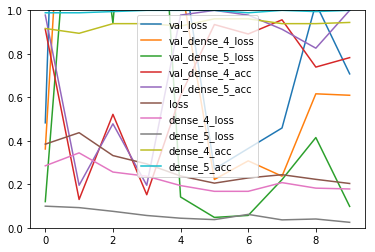

In [68]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))